In [146]:
# Problema 1: Formato do arquivo (separação das palavras)
# Problema 2: Quantidade de colunas variável

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np
from operator import is_not
from functools import partial

%matplotlib inline

In [147]:
input = pd.DataFrame([line.strip().split(';') for line in open('AntBNC_lemmas_ver_002.txt', 'r')])

In [148]:
input.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,h,aaahed,aaah,None,None,None,None,None,None,None,None,None,None
1,aac,aac,aacs,None,None,None,None,None,None,None,None,None,None
2,aah,aah,aahs,aahing,aahed,aahhing,None,None,None,None,None,None,None
3,aam,aams,aam,None,None,None,None,None,None,None,None,None,None
4,aardvark,aardvark,aardvarks,None,None,None,None,None,None,None,None,None,None


In [149]:
x = []
y = []
for row in input.values:
    linha = [''.join(row[:1]), [x for x in row[1:] if x is not None]]
    x.append(len(linha[0]))
    y.append(len(linha[1]))
    print("Tamanho: "+str(len(linha[0])) + " / Qtd Lemas: " + str(len(linha[1])))

Tamanho: 1 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 5
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 2 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Taman

Tamanho: 12 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 2 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 2 / Qtd Lemas: 4
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 10 / Qtd Lemas: 2
T

Tamanho: 14 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 

Tamanho: 3 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 8
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 2 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho

Tamanho: 7 / Qtd Lemas: 3
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 2
Tamanho

Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 6
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 6 / Qtd Lemas: 3
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 4
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Le

Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 4 / Qtd Lemas: 3
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 5
Tamanho: 12 / Qtd Lemas: 2
Taman

Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 3
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 4
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 9 / Qtd Le

Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 3
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 2 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tama

Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 3
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 6
Tamanho: 11 / Qtd Lemas: 2
Taman

Tamanho: 18 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 3
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho

Tamanho: 11 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Taman

Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
T

Tamanho: 11 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 4
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 3
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Taman

Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 5
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 6
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tam

Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 3
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 3
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 3
Tamanho: 17 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 3
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2


Tamanho: 4 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 3
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 16 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas

Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 5
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
T

Tamanho: 10 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lem

Tamanho: 7 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 16 / Qtd Lemas: 2
Tamanho: 15 / Qtd Lemas: 2
Tamanho: 19 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 16 / Qtd Lemas: 2
Tamanho: 16 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 15 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 5
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 4
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 15 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 16 / Qtd Lemas: 2
Tamanho: 16 / Qtd Lemas: 2
Tamanho: 18 / Qtd Lemas: 2
Tamanho: 

Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 17 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 15 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 4
Tamanho: 10 / Qtd Lemas: 4
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 15 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 3
Tamanho: 11 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lema

Tamanho: 10 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lema

Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 10 / Qtd Lemas: 2
T

Tamanho: 9 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 18 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 14 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qt

Tamanho: 6 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 8 / Qtd Lemas: 3
Tamanho: 6 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 3
Tamanho: 12 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanh

Tamanho: 8 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 4
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 3
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 3
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 3
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 15 / Qtd Lemas: 2
Tamanho: 15 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 2
Tama

Tamanho: 9 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 7 / Qtd Lemas: 2
Tamanho: 2 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 4
Tamanho: 4 / Qtd Lemas: 3
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 8 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 3
Tamanho: 7 / Qtd Lemas: 3
Tamanho: 4 / Qtd Lemas: 4
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 4 / Qtd Lemas: 5
Tamanho: 5 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 6
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 3 / Qtd Lemas: 2
Tamanho: 6 / Qtd Lemas: 3
Tamanho: 12 / Qtd Lemas: 3
Tamanho: 13 / Qtd Lemas: 2
Tamanho: 9 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 3
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 10 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 4
Tamanho: 7 / Qtd Lemas: 4
Tamanho: 11 / Qtd Lemas: 2
Tamanho: 12 / Qtd Lemas: 2
Tamanho: 15 / Qtd Lemas: 2
Tamanho: 5 / Qtd Lemas: 6
Tamanho: 6 / Qtd Lemas: 2
Ta

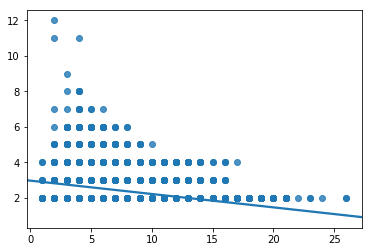

In [150]:
sb.regplot(x=np.array(x), y=np.array(y))

In [168]:
x1 = np.asarray(x)
x1 = x1.reshape(-1, 1)

y1 = np.asarray(y)
y1 = y1.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x1,y1, test_size=0.2, random_state=1)

In [169]:
regr = linear_model.LinearRegression()

In [170]:
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [171]:
y_pred = regr.predict(x_test)

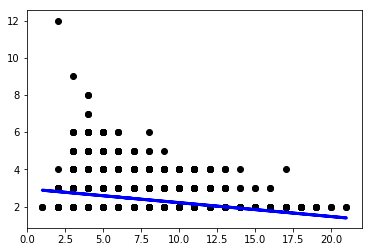

In [172]:
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, y_pred, color='blue', linewidth=3)